# Fashion-MNIST FF-Neural Network torch intro
The `torch.nn` namespace provides all the building blocks you need to build your own neural network. 

Every module in PyTorch subclasses the `nn.Module`.

In [1]:
import os
import torch
from torch import nn

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### Define a FF-Neural Network class
We define our neural network by subclassing nn.Module, and initialize the neural network layers in `__init__`. 

Every `nn.Module `subclass implements the operations on input data in the forward method.

Below, before we call the forward of the feed-forward method we **flatten** the input tensor. In many cases, such as in cases of image data, the data is represented as a multi-dimensional array of tensor, for example [batch_size, 28, 28] for a batch of images with 28x28 pixels. To make such data compatible with a standard fully connected we have to flatten it so that each pixel correspond to a neuron in the network at the input 

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x) # call class flatten method
        logits = self.linear_relu_stack(x) # call the forward pass for the neural network
        return logits

We create an instance of `NeuralNetwork`, and move it to the `device`

In [4]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model’s `forward`, along with some background operations. Do not call `model.forward()` directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output. We get the prediction probabilities by passing it through an instance of the `nn.Softmax` module.

In [5]:
X = torch.rand(1, 28, 28, device=device) # batch of single 28x28 'pixel' image as input data
logits = model(X) # yields the final layer neuron outputs
pred_probab = nn.Softmax(dim=1)(logits) # creates prob of these outputs corresponding to different classes by using the softmax function
y_pred = pred_probab.argmax(1) # Takes the argment with the largest prob as the predicted class 
print(f"Predicted class: {y_pred}") # predicts class from the total of 10 classes

Predicted class: tensor([6], device='mps:0')


In this network, w and b are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the requires_grad property of those tensors.

#### Load Data

In [6]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root = "data", # path where data will be stored
    train = True, # 
    download = True,
    transform=ToTensor() # convert ndarray to torch.tensor
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [7]:
print(training_data)
print(test_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


Load the dataset with a specific batch size

In [8]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

#### Define Hyperparameters

Define the following hyperparameters for training:
- **Number of Epochs** - the number times to iterate over the dataset
- **Batch Size** - the number of data samples propagated through the network before the parameters are updated
- **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [9]:
lr = 1e-3
bs = 64
epochs = 5

### Optimization loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.

Each epoch consists of two main parts:
- The Train Loop - iterate over the training dataset and try to converge to optimal parameters.
- The Validation/Test Loop - iterate over the test dataset to check if model performance is improving.

#### Loss function
 Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

 Common loss functions include nn.MSELoss (Mean Square Error) for regression tasks

nn.NLLoss (Negative Log Likelihood) for classification

nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss to yield a probabiliy in our prediction

In [10]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

#### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. 

Optimization algorithms define how this process is performed (in this example we use Stochastic Gradient Descent). All optimization logic is encapsulated in the optimizer object.

Initalize the optimizer by passing the model's parameters that need to be trained, and passing any optimizer relevant hyperparameters such as learning rate.

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr= lr) 

Inside the training loop, optimization happens in three steps:

- Call optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
- Backpropagate the prediction loss with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.
- Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.

### Training and Test Loop
We define train_loop that loops over our optimization code, and test_loop that evaluates the model’s performance against our test data.

The training loop consists of:
1) Setting the model to train
2) Iterate over each batch, get the features and labels
3) For each batch, obtain the model predictions
4) Compute the loss (deviation from model pred to true label)
5) Start backpropagation by computing the gradients wrt to each parameter of each node to obtain the change to derivative of the loss function
6) Adjust the node parameters (weight and biases) by the gradients
7) Reset th gradients of the model to prepare for the next batch

In [25]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        
        # Move the data to the device (GPU or MPS)
        X = X.to(device)
        y =y.to(device)
        
        # Get prediction and compute loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Back-prop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() 
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * bs + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0 # tally the number of correct predictions
    
   # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    
    with torch.no_grad():
        for X, y in dataloader:
            
            # Move the data to the device (GPU or MPS)
            X = X.to(device)
            y =y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    # TODO: Explain the two steps below
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
        

#### Training and Test loop execution

In [26]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 1.891896  [   64/60000]
loss: 1.867726  [ 6464/60000]
loss: 1.732750  [12864/60000]
loss: 1.770723  [19264/60000]
loss: 1.671376  [25664/60000]
loss: 1.620758  [32064/60000]
loss: 1.636911  [38464/60000]
loss: 1.540162  [44864/60000]
loss: 1.565440  [51264/60000]
loss: 1.464948  [57664/60000]
Test Error: 
 Accuracy: 61.4%, Avg loss: 1.484152 

Epoch 2
-------------------------------
loss: 1.553514  [   64/60000]
loss: 1.529315  [ 6464/60000]
loss: 1.366726  [12864/60000]
loss: 1.444998  [19264/60000]
loss: 1.329574  [25664/60000]
loss: 1.320425  [32064/60000]
loss: 1.337247  [38464/60000]
loss: 1.260398  [44864/60000]
loss: 1.301708  [51264/60000]
loss: 1.212306  [57664/60000]
Test Error: 
 Accuracy: 63.8%, Avg loss: 1.232651 

Epoch 3
-------------------------------
loss: 1.306572  [   64/60000]
loss: 1.298569  [ 6464/60000]
loss: 1.123892  [12864/60000]
loss: 1.238328  [19264/60000]
loss: 1.112033  [25664/60000]
loss: 1.128571  [32064/600

### Check single predictions

In [97]:
subset_indices = [1] # select your indices here as a list
subset = torch.utils.data.Subset(train_dataloader.dataset, subset_indices)
testloader_subset = torch.utils.data.DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)

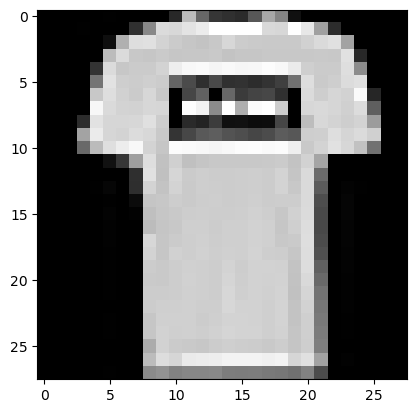

Actual class: T-shirt/top 
Predicted class: T-shirt/top


In [98]:
import numpy as np
import matplotlib.pyplot as plt 


# Function to map integer labels to corresponding class names
def get_class_name(label):
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    return classes[label]

for x, y in testloader_subset:
    model.eval()
    model_pred = model(x.to(device))
    model_pred = model_pred.detach().cpu().numpy().argmax(1)[0]
    x = x.squeeze().detach().numpy()
    plt.imshow(x, cmap='gray')
    plt.show()
    print(f"Actual class: {get_class_name(y.detach().cpu().numpy()[0])} \nPredicted class: {get_class_name(model_pred)}")
